# Homework 2 - UNet autoencoder in denoising images
## Peter Yegorov

This project investigates the efficacy of the UNet autoencoder for image denoising, employing the UNet architecture trained on noisy MNIST datasets. It aims to evaluate the denoising accuracy of the UNet model across datasets subjected to various levels of noise, introduced through different standard deviation values.

### Image Denoising with UNet
In the context of image denoising, the UNet autoencoder is trained to learn the mapping from noisy images to their clean counterparts. The input to the network is a noisy image, and the target output is the clean, denoised image. Through the training process, the network learns to filter out the noise while retaining the important features and structures of the image.

### Core Components of UNet Autoencoder
#### Contracting Path (Encoder)
This portion of the network consists of several layers of convolution and pooling operations. As the input image progresses through the encoder, its spatial dimensions are reduced while its depth (the number of channels) increases. In the figure below, the initial size of the MNIST picture is 28x28, but then it is reduced by max pooling to 14x14 in the layer right before x2, 7x7 in the layer right before x3 - and so on. On the other hand, Conv2d convolutions create layers with up to 512 feature maps depth. This process captures the contextual information necessary for understanding the image features at various scales.

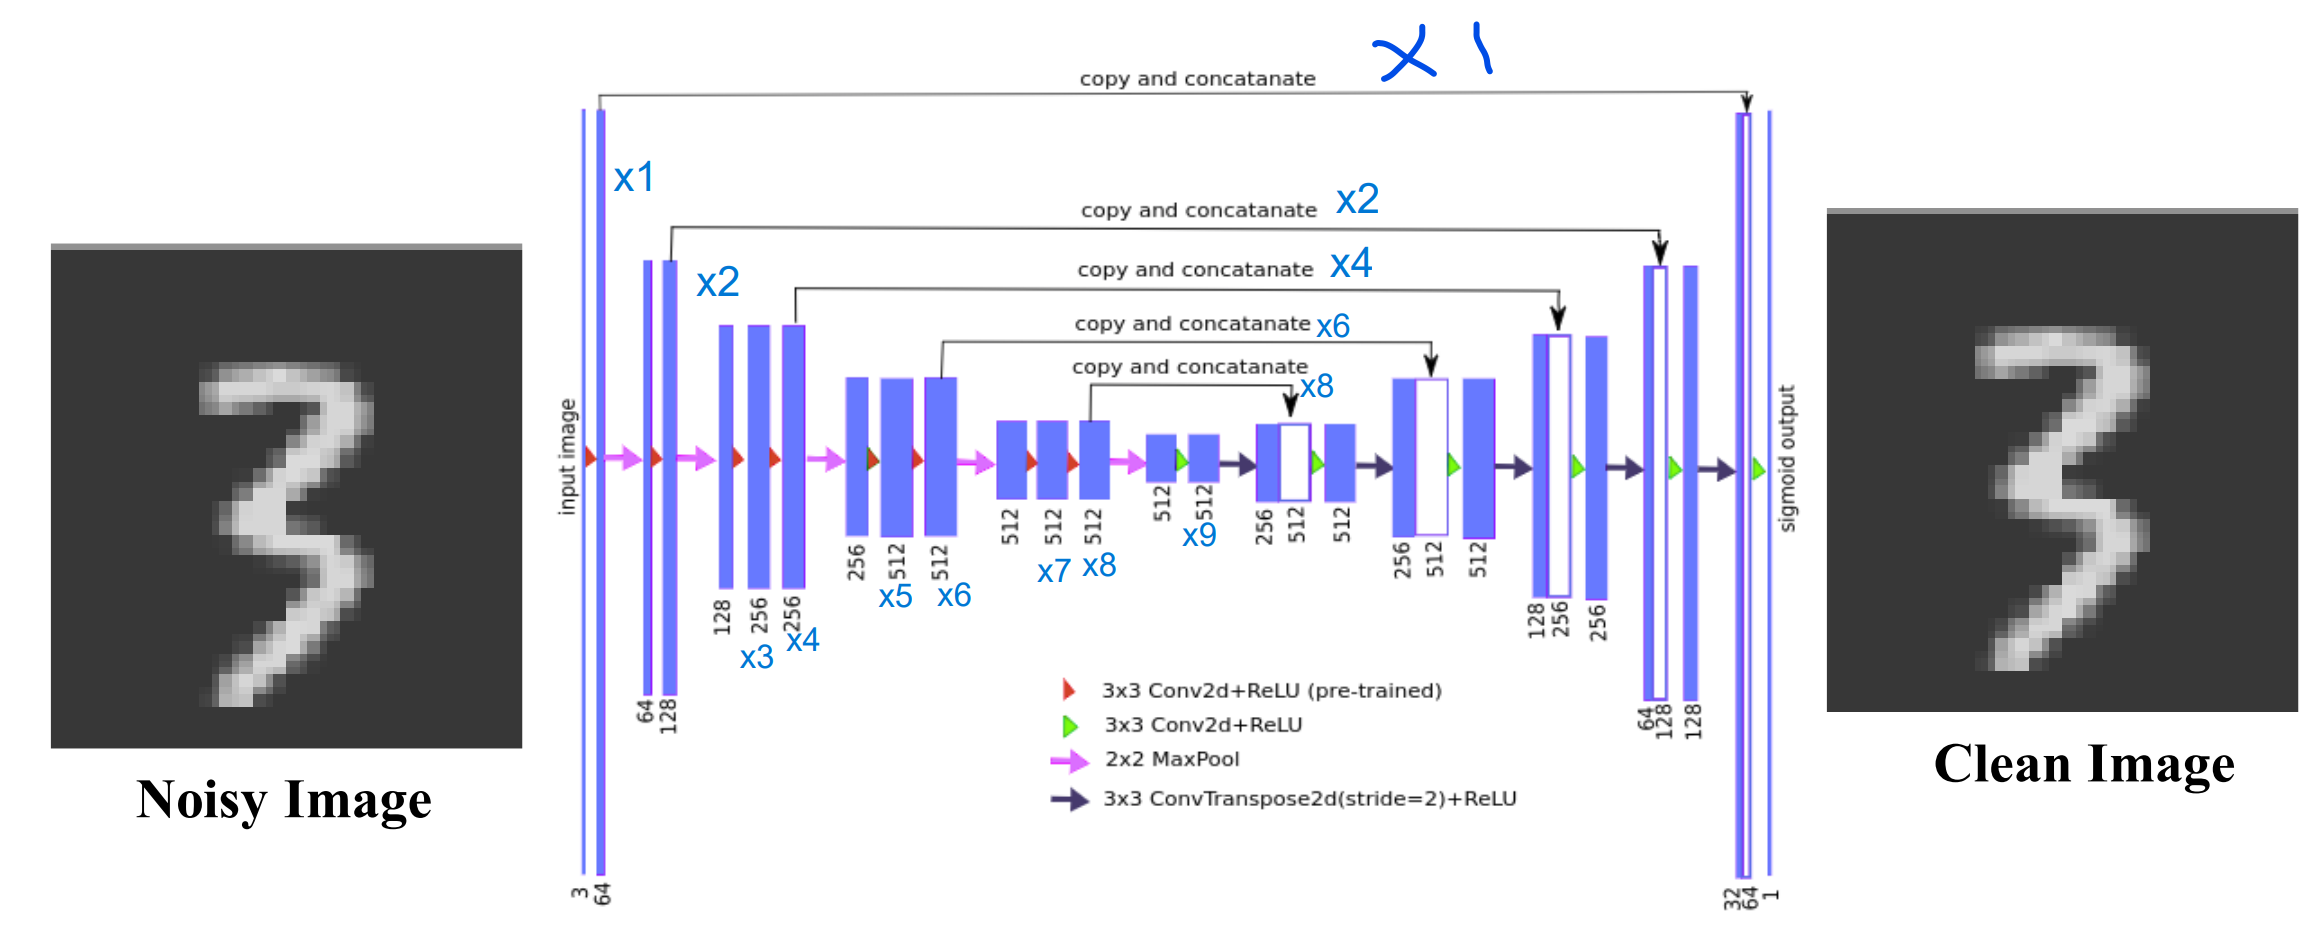

#### Expanding Path (Decoder)
The decoder consists of concatenation followed by up-convolution and transpose convolution operations. This structure gradually restores the spatial dimensions of the processed image. Importantly, it uses skip connections from the encoder to the decoder, allowing the network to use fine-grained details from the input image in the reconstruction phase.

#### Skip Connections
These are direct connections between the layers of the encoder and the corresponding layers of the decoder. They help in transferring fine-grained details that might be lost during the encoding process, facilitating more precise reconstruction or segmentation of images.

### Plan:
1. Use the MNIST dataset and add Gaussian noise to 80% of the pixels in each image in the training dataset.
2. Use the newly created noisy training dataset and train the UNet architecture to perform denoising.
3. Plot the learning curve (MSE vs iteration).
4. Add several different amount of Gaussian noise to MNIST test images and use the trained UNet to denoise these images. Visualize the results.

### 1. This code snippet loads the MNIST dataset, introduces Gaussian noise to the images with varying standard deviations (50, 35, 25, and 15), and then visualizes the first 10 original and noisy (std = 50) training images in a 2-row matplotlib figure. The function add_gaussian_noise selectively applies noise to 80% of the pixels in each image, simulating different levels of image degradation.

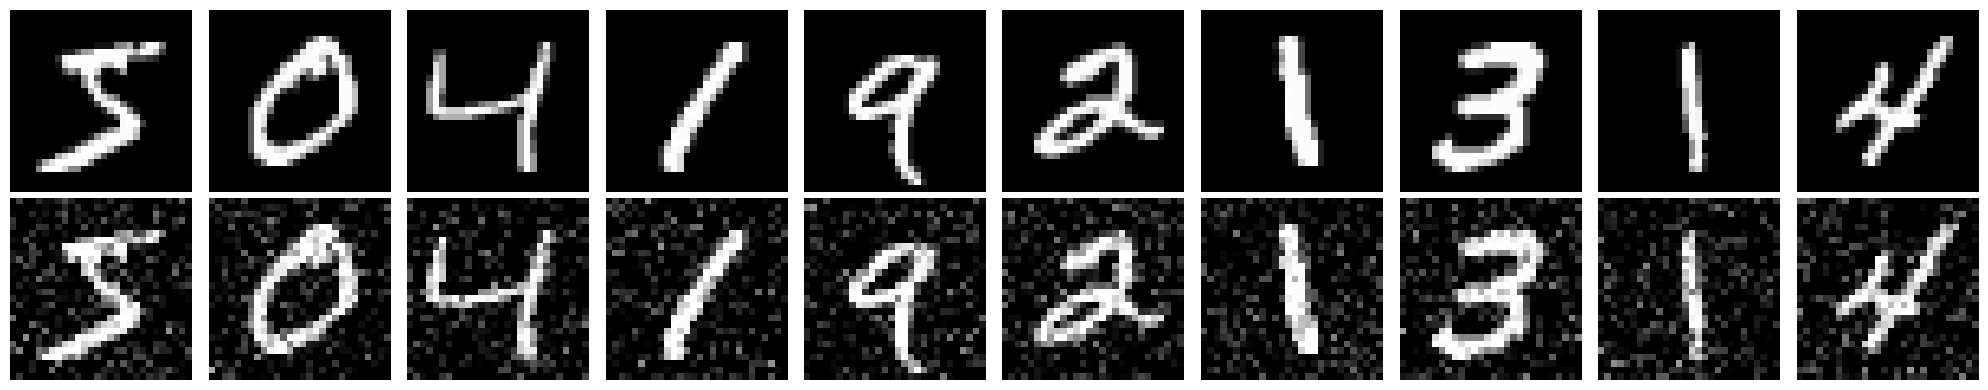

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


# Add Gaussian noise to 80% of the pixels with variable sigma
def add_gaussian_noise_2(image, sigma):
    noise = np.random.normal(0, sigma, image.shape)
    noised_image = image + noise
    return np.clip(noised_image, 0, 255)

def add_gaussian_noise(images, mean=0, std=50, noise_factor=0.8):
    """
    Add Gaussian noise to the images.
    - images: Array of images
    - mean: Mean of the Gaussian noise
    - std: Standard deviation of the Gaussian noise
    - noise_factor: Percentage of pixels to be noised
    """
    noisy_images = []
    for image in images:
        # Flatten the image for pixel-wise manipulation
        flat_image = image.flatten()

        # Randomly select 80% of pixels
        pixels_to_noise = np.random.choice(len(flat_image), size=int(0.8 * len(flat_image)), replace=False)

        # Add Gaussian noise to the selected pixels with the current sigma
        flat_image[pixels_to_noise] = add_gaussian_noise_2(flat_image[pixels_to_noise], std)

        # Reshape the image back to its original shape
        noised_image = flat_image.reshape(image.shape)

        noisy_images.append(noised_image)

    return np.array(noisy_images)

# Load MNIST dataset
(train_images, _), (test_images, _) = mnist.load_data()

# Add Gaussian noise to training images
noisy_train_images = add_gaussian_noise(train_images)
noisy_test_images_std_50 = add_gaussian_noise(test_images)
noisy_test_images_std_35 = add_gaussian_noise(test_images, std=35)
noisy_test_images_std_25 = add_gaussian_noise(test_images, std=25)
noisy_test_images_std_15 = add_gaussian_noise(test_images, std=15)

# Displaying a few original and noisy images
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Original images
    ax = axes[0, i]
    ax.imshow(train_images[i, :, :], cmap='gray')
    ax.axis('off')
    # Noisy images
    ax = axes[1, i]
    ax.imshow(noisy_train_images[i, :, :], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


### 2-3
This code defines and trains a U-Net architecture for an image denoising task, specifically designed to clean up MNIST images that have been artificially noised with Gaussian noise.

Key components of the code include:

DoubleConv: A module that performs two sequential operations: a convolution followed by batch normalization and ReLU activation. This module is used repeatedly in both the downsampling (encoder) and upsampling (decoder) paths of the U-Net architecture.

UNet: The neural network model that implements the U-Net architecture. It consists of a series of downsampling layers to encode the input image into a compressed representation, followed by upsampling layers that decode this representation back to the image's original dimensions. Skip connections are used to concatenate feature maps from the encoder path with those in the decoder path.

Training Process: The code converts the original and noised MNIST images into PyTorch tensors, creates a DataLoader for batching operations, and defines a training loop. During each epoch, the model takes in a batch of noised images, attempts to denoise them, and calculates the loss using the mean squared error (MSE) between the model's output and the clean images. The optimizer uses this loss to adjust the model's parameters.

Loss Plotting: After training, the code plots the training loss over epochs, providing insight into the model's learning progress.

Training on cuda
Epoch 1, Loss: 442.1353454589844
Epoch 2, Loss: 132.1656951904297
Epoch 3, Loss: 136.70529174804688
Epoch 4, Loss: 138.02000427246094
Epoch 5, Loss: 139.38551330566406
Epoch 6, Loss: 115.92807006835938
Epoch 7, Loss: 123.23487091064453
Epoch 8, Loss: 119.11540985107422
Epoch 9, Loss: 118.89749908447266
Epoch 10, Loss: 125.033935546875


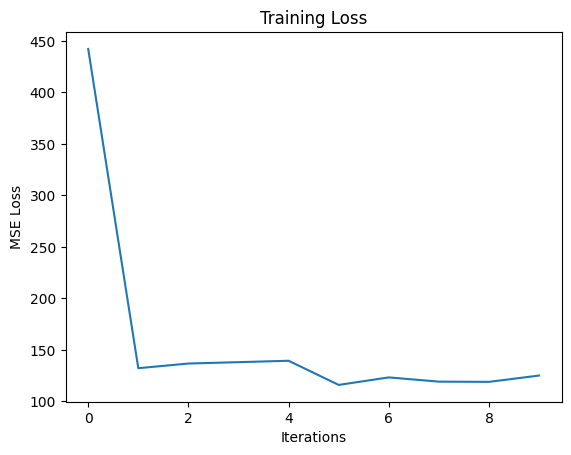

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU)"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(1, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 256)
        self.down5 = DoubleConv(256, 512)
        self.down6 = DoubleConv(512, 512)
        self.down7 = DoubleConv(512, 512)
        self.down8 = DoubleConv(512, 512)
        self.down9 = DoubleConv(512, 512)
        
        self.maxpool = nn.MaxPool2d(2)
        
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=1, stride=2)
        self.conv1 = DoubleConv(768, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2)
        self.conv2 = DoubleConv(768, 512)
        self.up3 = nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2)
        self.conv3 = DoubleConv(384, 256)
        self.up4 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(192, 128)
        self.up5 = nn.ConvTranspose2d(128, 32, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(96, 1)

    def forward(self, x): 
        x1 = self.down1(x)
        x2 = self.down2(self.maxpool(x1))
        x3 = self.down3(self.maxpool(x2))
        x4 = self.down4(x3)
        x5 = self.down5(self.maxpool(x4))
        x6 = self.down6(x5)
        x7 = self.down7(self.maxpool(x6))
        x8 = self.down8(x7)
        x9 = self.down9(x8)

        x = self.up1(x9)
        x = self.conv1(torch.cat([x, x8], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x6], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x4], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x, x2], dim=1))
        x = self.up5(x)
        x = self.conv5(torch.cat([x, x1], dim=1))

        return x

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Training on {device}")

# Convert numpy arrays to PyTorch tensors and move them to the selected device
train_tensor = torch.tensor(train_images).float().unsqueeze(1).to(device)
noisy_train_tensor = torch.tensor(noisy_train_images).float().unsqueeze(1).to(device)

# Create datasets and dataloaders
train_dataset = TensorDataset(noisy_train_tensor, train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model, move it to the device, and set up the loss function and optimizer
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.04)

# Training loop
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    for noisy_imgs, imgs in train_loader:
        noisy_imgs, imgs = noisy_imgs.to(device), imgs.to(device)  # Move inputs to the device
        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    losses.append(loss.item())

# Plotting the learning curve
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.show()


### 4.
This section of code focuses on evaluating the U-Net model's performance in denoising test images from the MNIST dataset, which have been artificially noised with Gaussian noise at different standard deviations (50, 35, 25, and 15). 

Key steps and their purposes are:

Prepare the Noisy Test Set: The noisy test images are already prepared using the add_gaussian_noise function for different levels of noise intensity, simulating real-world scenarios where images may be corrupted by varying degrees of noise.

Convert Noisy Test Images to Tensors: Each set of noisy test images is converted into PyTorch tensors, ensuring they are in the correct format and moved to the GPU.

Model Evaluation: The model is set to evaluation mode (model.eval()) to disable dropout or batch normalization layers that are not needed during inference. Using torch.no_grad() to avoid tracking gradients, which saves memory and computations, the model predicts the denoised images from the noisy test tensors.

Visualization: The denoised images are converted back to numpy arrays for visualization. A function, plot_examples, is defined and used to plot a comparison between original, noisy, and denoised images across the different noise levels. This visual comparison helps in assessing the effectiveness of the denoising process under various noise conditions.



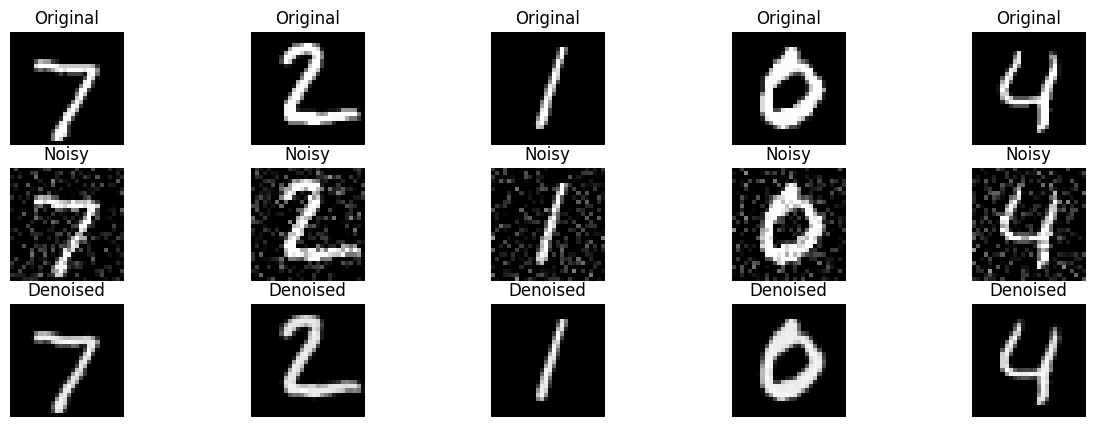

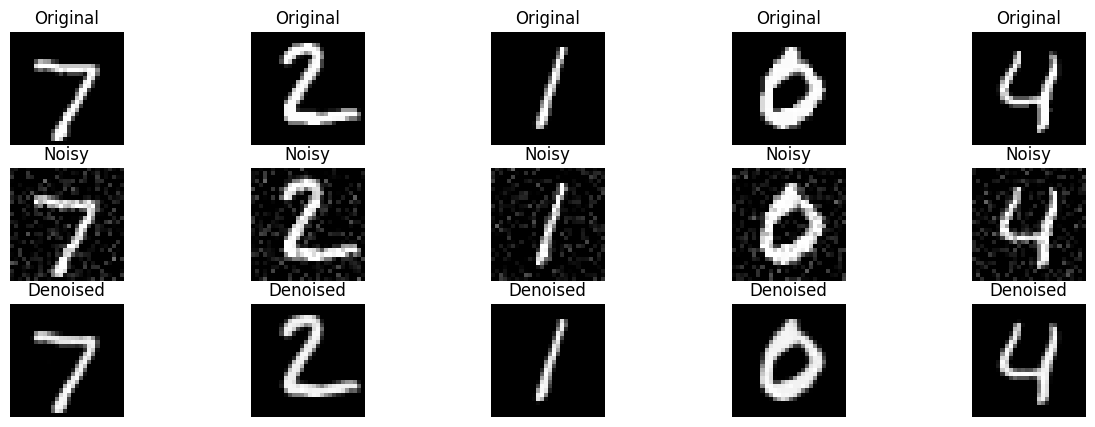

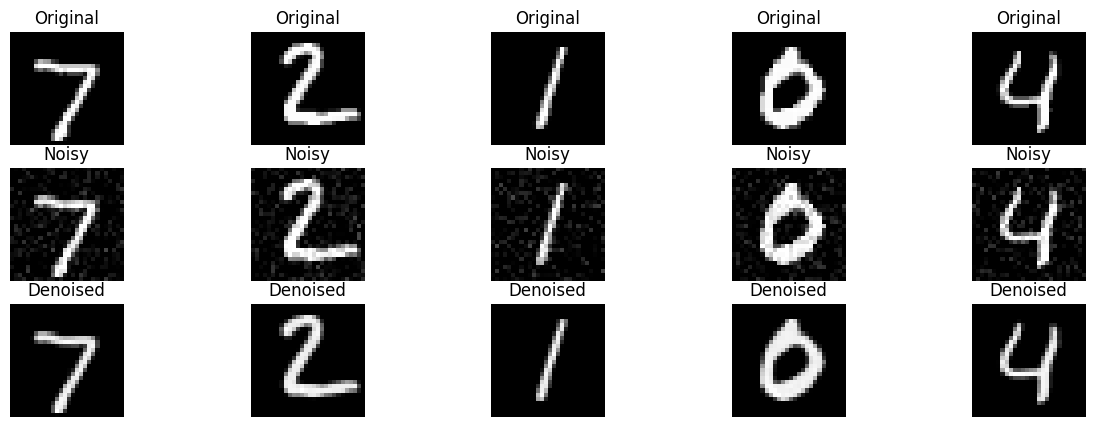

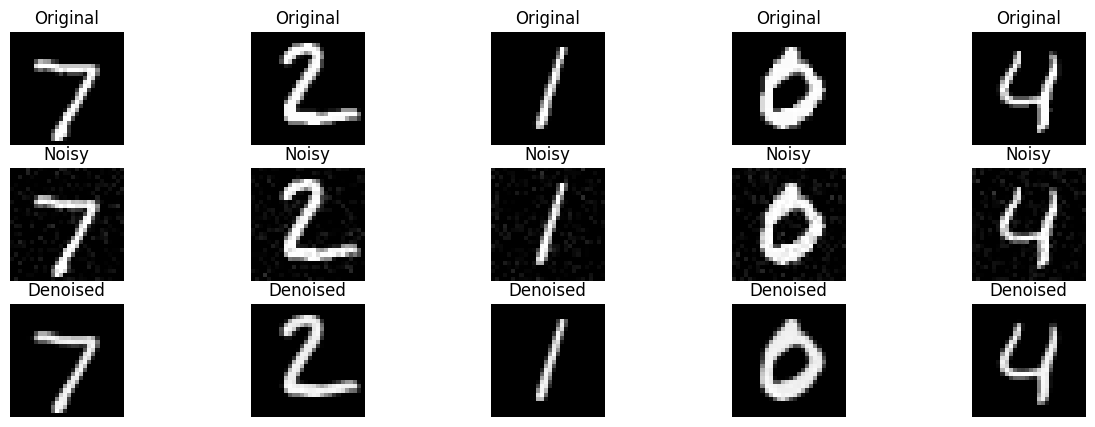

In [3]:

# Convert noisy test images to PyTorch tensors
noisy_test_tensor_50 = torch.tensor(noisy_test_images_std_50).float().unsqueeze(1).to(device)
noisy_test_tensor_35 = torch.tensor(noisy_test_images_std_35).float().unsqueeze(1).to(device)
noisy_test_tensor_25 = torch.tensor(noisy_test_images_std_25).float().unsqueeze(1).to(device)
noisy_test_tensor_15 = torch.tensor(noisy_test_images_std_15).float().unsqueeze(1).to(device)

# Ensure the model is in evaluation mode
model.eval()

# No gradient computation for testing
with torch.no_grad():
    denoised_images_50 = model(noisy_test_tensor_50)
    denoised_images_35 = model(noisy_test_tensor_35)
    denoised_images_25 = model(noisy_test_tensor_25)
    denoised_images_15 = model(noisy_test_tensor_15)
    

# Convert back to numpy for visualization
denoised_images_np_50 = denoised_images_50.cpu().numpy().squeeze()
denoised_images_np_35 = denoised_images_35.cpu().numpy().squeeze()
denoised_images_np_25 = denoised_images_25.cpu().numpy().squeeze()
denoised_images_np_15 = denoised_images_15.cpu().numpy().squeeze()

# Step 3: Plot some denoising examples
def plot_examples(noisy_images, denoised_images, original_images, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Plot original image
        plt.subplot(3, n, i+1)
        plt.imshow(original_images[i], cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        # Plot noisy image
        plt.subplot(3, n, n+i+1)
        plt.imshow(noisy_images[i], cmap='gray')
        plt.title('Noisy')
        plt.axis('off')
        
        # Plot denoised image
        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(denoised_images[i], cmap='gray')
        plt.title('Denoised')
        plt.axis('off')
    
    plt.show()

# Select a few samples and plot the results
plot_examples(noisy_test_images_std_50[:5], denoised_images_np_50[:5], test_images[:5])
plot_examples(noisy_test_images_std_35[:5], denoised_images_np_35[:5], test_images[:5])
plot_examples(noisy_test_images_std_25[:5], denoised_images_np_25[:5], test_images[:5])
plot_examples(noisy_test_images_std_15[:5], denoised_images_np_15[:5], test_images[:5])


### Result: Denoising was successful for different values of sigma (50 - example 1, 35 - example 2, 25 - example 3, 15 - example 4) 